In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Change to my working directory
!cd /content/drive/MyDrive

In [3]:
# Set image and mask paths
image_path = "/content/drive/MyDrive/ADE/imgs/"
mask_path = "/content/drive/MyDrive/ADE/masks/"


In [4]:
with open("/content/drive/MyDrive/ADE/test.txt", "r") as file:
    file_names = file.read().splitlines()
test_x = [image_path + "ADE_val_" + test_name + ".jpg" for test_name in file_names]
test_y = [mask_path + "ADE_val_" + test_name + "_seg.png" for test_name in file_names]
with open("/content/drive/MyDrive/ADE/train.txt", "r") as file:
    file_names = file.read().splitlines()
train_x = [image_path + "ADE_val_" + train_name + ".jpg" for train_name in file_names]
train_y = [mask_path + "ADE_val_" + train_name + "_seg.png" for train_name in file_names]
with open("/content/drive/MyDrive/ADE/val.txt", "r") as file:
    file_names = file.read().splitlines()
val_x = [image_path + "ADE_val_" + val_name + ".jpg" for val_name in file_names]
val_y = [mask_path + "ADE_val_" + val_name + "_seg.png" for val_name in file_names]

In [5]:
#(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data()

print("Training data: ", len(train_x))
print("Validation data: ", len(val_x))
print("Test data: ", len(test_x))

Training data:  1400
Validation data:  200
Test data:  400


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [8]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)
model = UNet(3,3)

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

In [10]:
class UNetDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        mask = cv2.imread(self.masks[index])  # Read as grayscale

        image = cv2.resize(image, (256, 256))
        mask = cv2.resize(mask, (256, 256))

        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [11]:
transform = ToTensor()
train_dataset = UNetDataset(train_x, train_y, transform)
test_dataset = UNetDataset(test_x, test_y, transform)
val_dataset = UNetDataset(val_x, val_y, transform)


torch.Size([3, 256, 256])


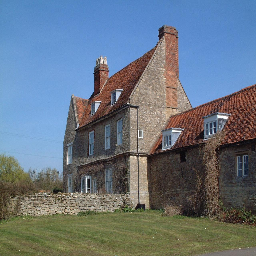

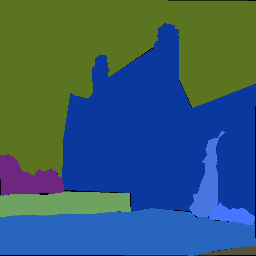

In [14]:
import cv2
import numpy as np
img,mask = train_dataset[0]     # 返回第一張圖像及box和對應的類别
print(img.shape)
from google.colab.patches import cv2_imshow
img_ = (img.numpy()*255).astype(np.uint8).transpose(1,2,0)
cv2_imshow(img_)
img_ = (mask.numpy()*255).astype(np.uint8).transpose(1,2,0)
cv2_imshow(img_)


In [15]:
batch_size = 8
shuffle = True

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [16]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in train_dataloader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_dataloader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}')


KeyboardInterrupt: ignored

torch.Size([3, 256, 256])


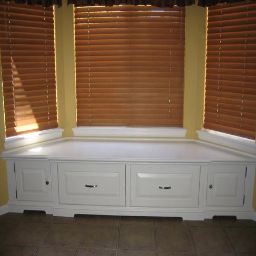

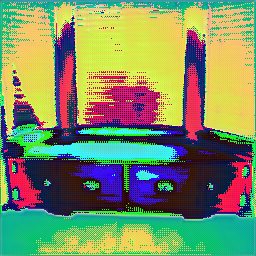

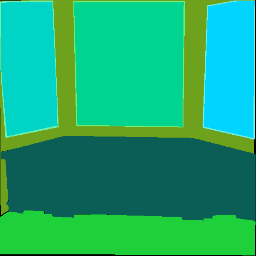

In [22]:
img,output,mask = images[0],outputs[0],masks[0]     # 返回第一張圖像及box和對應的類别
print(img.shape)
from google.colab.patches import cv2_imshow
img_ = (img.detach().cpu().numpy()*255).astype(np.uint8).transpose(1,2,0)
cv2_imshow(img_)
img_ = (output.detach().cpu().numpy()*255).astype(np.uint8).transpose(1,2,0)
cv2_imshow(img_)
img_ = (mask.cpu().numpy()*255).astype(np.uint8).transpose(1,2,0)
cv2_imshow(img_)

In [23]:
model.eval()
val_loss = 0.0

with torch.no_grad():
    for images, masks in val_dataloader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        val_loss += loss.item() * images.size(0)

    val_loss /= len(val_dataloader.dataset)

    print(f'Validation Loss: {val_loss:.4f}')


Validation Loss: 0.6296
